# SnowGW Exploratory Data Analysis (EDA)

---

### Preliminary visualization

Time series plots of all variables

In [1]:
import numpy as np
import pandas as pd

# scipy statistics package
import scipy.stats as st

# for plotting
import matplotlib.pyplot as plt
# tell jupyter to show our plots in the notebook here
%matplotlib inline

Load in a csv

In [2]:
data = pd.read_csv('data/mashupdata.csv')

data.head(3)

,prcp,et,disch,swe,stn_swe,gw,month,year
0,334.104779,4.429900,153.008225,65.746676,11.374194,63.449355,1,2008
1,168.820151,6.240035,110.803206,56.775266,20.479310,63.017931,2,2008
2,246.509770,18.118176,139.330672,33.609042,21.335484,62.409355,3,2008


In [3]:
df = data.loc[:,['prcp','et','disch','swe','stn_swe','gw']]

In [75]:
data['idx']=data.index.values
data

,prcp,et,disch,swe,stn_swe,gw,month,year,idx
0,334.104779,4.429900,153.008225,65.746676,11.374194,63.449355,1,2008,0
1,168.820151,6.240035,110.803206,56.775266,20.479310,63.017931,2,2008,1
2,246.509770,18.118176,139.330672,33.609042,21.335484,62.409355,3,2008,2
3,166.709809,29.985873,108.979532,38.354516,21.016667,61.869000,4,2008,3
4,140.920447,58.889454,238.139717,23.159861,6.587097,61.614194,5,2008,4
...,...,...,...,...,...,...,...,...,...
127,9.327344,88.816246,24.761881,0.000000,0.000000,62.231290,8,2018,127
128,29.181280,50.922320,24.334019,0.000000,0.000000,62.951333,9,2018,128
129,139.451311,9.706635,28.566545,0.000000,0.000000,62.861290,10,2018,129
130,197.800312,0.122301,53.184136,0.002197,0.140000,63.091000,11,2018,130


<AxesSubplot:>

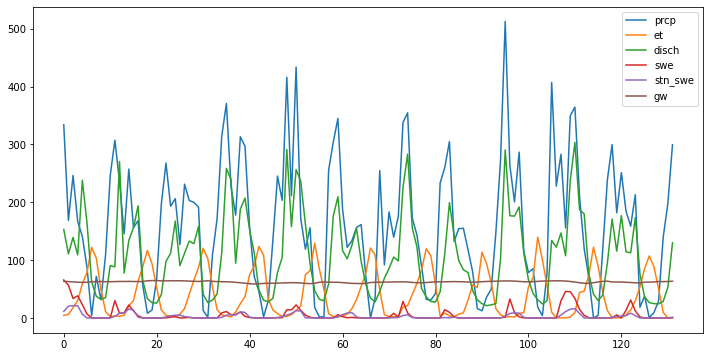

In [4]:
df.plot(figsize = (12,6))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

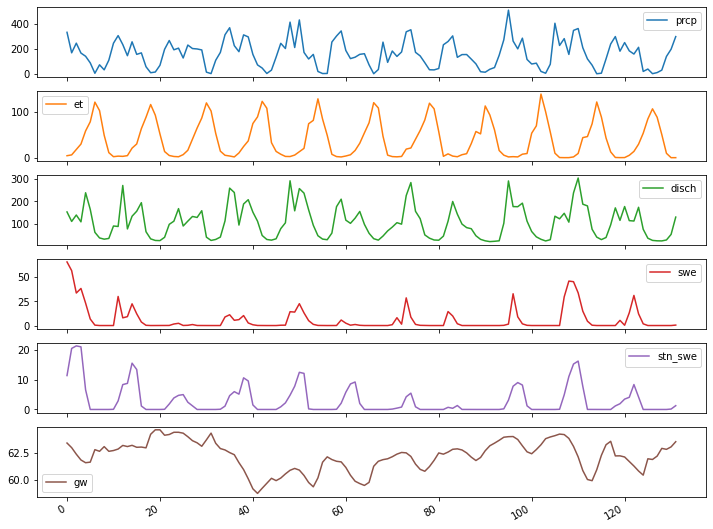

In [9]:
df.plot(figsize = (12,10),subplots=True)

In [ ]:
fig, ax = plt.subplots()

data.plot(x='years', y='SLI_max', c='b', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='r', ax=ax, label='Blue Canyon')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)')
ax.set_xlabel('Water Year')
ax.set_ylabel('Peak SWE (mm)');
plt.legend(loc="best")

Hydrograph/Hyetograph

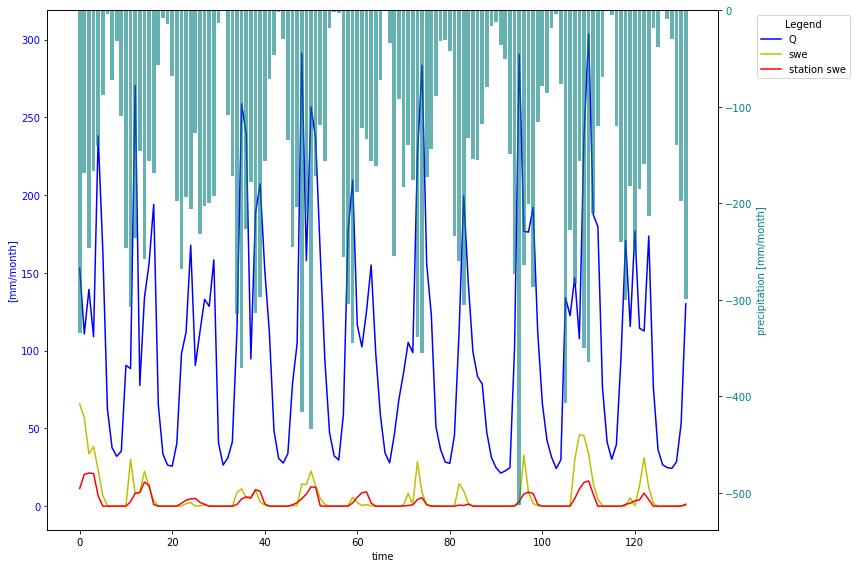

In [27]:
# From Nina's code

fig, ax1 = plt.subplots(figsize=(12,8))

color = 'b'
ax1.set_xlabel('time')
ax1.set_ylabel('[mm/month]', color=color)
p1,=ax1.plot(data.index.values,data['disch'], color=color, label='Q')
p2,=ax1.plot(data.index.values,data['swe'], color='y', label='swe')
p3,=ax1.plot(data.index.values,data['stn_swe'], color='r', label='station swe')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(handles=[p1, p2,p3], title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'teal'
ax2.set_ylabel('precipitation [mm/month]', color=color)  # we already handled the x-label with ax1
ax2.bar(data.index.values,-data['prcp'], color=color,alpha = .6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Other time series comparisons?

---

### Questions

**How correlated are Daymet and SNOTEL SWE?**
* Scatterplot Daymet ~ SNOTEL
* Estimate correlation coefficient

**How do Daymet and SNOTEL distributions compare? Are there aggregation differences (e.g., Daymet more smooth than SNOTEL, SNOTEL greater magnitude)?**
* Histogram or density plots

**What predictors is discharge most correlated with?**
* Multiple linear regression of discharge on water storage, GW levels, SWE, and precipitation

**What are the lags between water storage, SWE, and discharge? How do we interpret them?**
* Visualizations; differences between seasonal peaks

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Scatterplot</b></br>
</div>

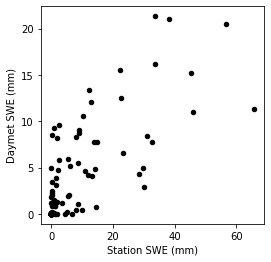

In [30]:
fig, ax = plt.subplots(figsize=(4,4))

# Scatterplot
data.plot.scatter(x='swe', y='stn_swe', c='k', ax=ax);

ax.set_xlabel('Station SWE (mm)')
ax.set_ylabel('Daymet SWE (mm)');

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Distributions</b></br>
</div>

<AxesSubplot:>

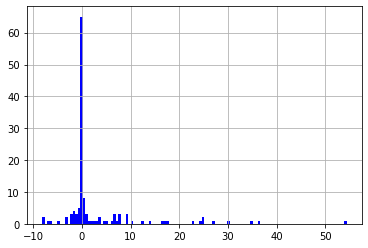

In [35]:
dif = data['swe']-data['stn_swe']
dif.hist(bins=120, color = 'b')

<AxesSubplot:>

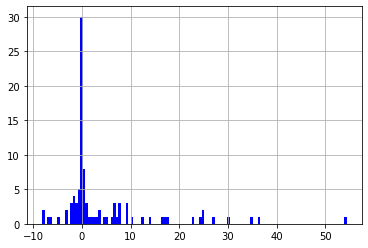

In [36]:
# From Nina's code
dif = dif[dif!=0]
dif.hist(bins=120, color = 'b')

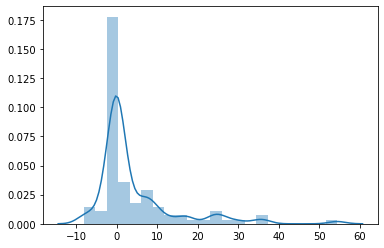

In [37]:
# From Nina's code
import seaborn as sns
ax = sns.distplot(dif)

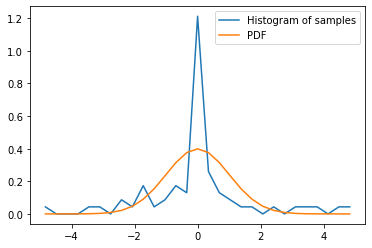

In [38]:
# From Nina's code

# Sample from a normal distribution using numpy's random number generator
samples = dif

# Compute a histogram of the sample
bins = np.linspace(-5, 5, 30)
histogram, bins = np.histogram(samples, bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
pdf = stats.norm.pdf(bin_centers)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples")
plt.plot(bin_centers, pdf, label="PDF")
plt.legend()
plt.show()

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Regression</b></br>
</div>

**Linear regression**: regression of discharge on water storage, GW levels, SWE, and precipitation

In [ ]:
st.linregress?

In [132]:
var1 = data['swe']
nam1 = 'swe'
var2 = data['et']
nam2 = 'et'
# use the linear regression function
slope, intercept, rvalue, pvalue, stderr = st.linregress(var1, var2)

print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

r-value = -0.33258678753859716
r-squared = 0.11061397124524397
p-value = 9.767193378894347e-05
standard error = 0.2752440738373971


Plot the result

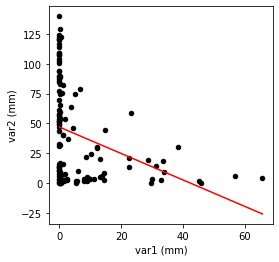

In [133]:
fig, ax = plt.subplots(figsize=(4,4))

# Scatterplot
data.plot.scatter(x=nam1, y=nam2, c='k', ax=ax);

# Create points for the regression line
x = np.linspace(var1.min(), var1.max(), var1.size) # x coordinates from min and max values of SLI_max
y = slope * x + intercept # y coordinates using the slope and intercept from our linear regression

# Plot the regression line
ax.plot(x, y, '-r')

ax.set_xlabel('var1 (mm)')
ax.set_ylabel('var2 (mm)');

In [128]:
residuals = var2 - y

For a good linear fit, we hope that our residuals are small, don't have any trends or patterns themselves, want them to be normally distributed:

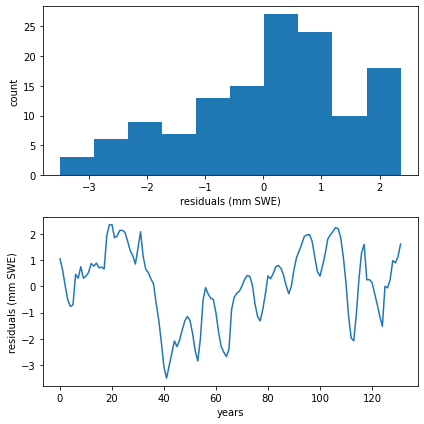

In [134]:
f, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))

ax1.hist(residuals)
ax1.set_xlabel('residuals (mm SWE)')
ax1.set_ylabel('count')


ax2.plot(data.idx,residuals)
ax2.set_xlabel('years')
ax2.set_ylabel('residuals (mm SWE)')

f.tight_layout()

That distribution doesn't look quite normal, and there seems to be a negative bias (our predictions are higher then the observations).

There doesn't seem to be a trend in the residuals over time, but they're very noisy.

Let's plot what the predictions of Blue Canyon SWE would look like if we were to use this linear model:

In [130]:
# Use our linear model to make predictions:
BLC_pred = slope * var1 + intercept

r-value = -0.33258678753859716
r-squared = 0.11061397124524397
p-value = 9.767193378894347e-05
standard error = 0.2752440738373971


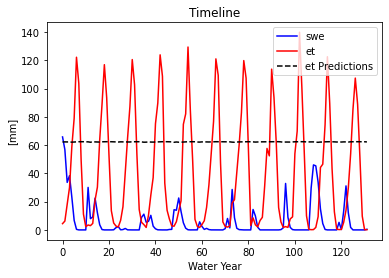

In [135]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

r-value = -0.07935355765893184
r-squared = 0.006296987113129421
p-value = 0.3657521217144103
standard error = 0.001702690146109112


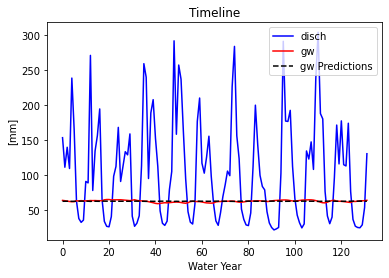

In [131]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

r-value = 0.013403500174924405
r-squared = 0.00017965381693919858
p-value = 0.8787636743397956
standard error = 0.02561942749372176


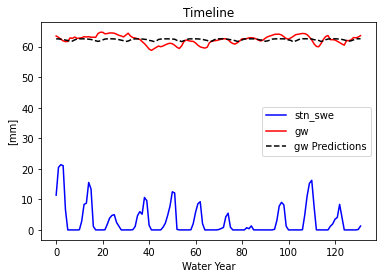

In [124]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

r-value = -0.20962678337869955
r-squared = 0.04394338830970023
p-value = 0.015848386629833486
standard error = 0.002978546069928999


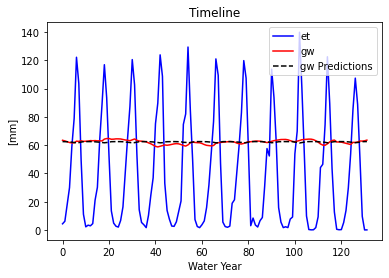

In [119]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

r-value = 0.09882554589999064
r-squared = 0.009766488522431156
p-value = 0.25958096504072564
standard error = 0.010087320713117543


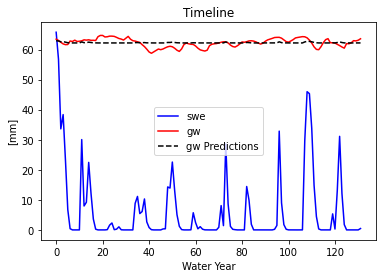

In [114]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

r-value = 0.13601864436584854
r-squared = 0.018501071615123182
p-value = 0.11992028069807771
standard error = 0.0010813312509674444


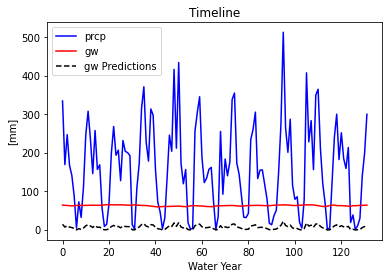

In [108]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

r-value = 0.4052677867835623
r-squared = 0.1642419790044469
p-value = 1.4329673533469309e-06
standard error = 0.008633271941136628


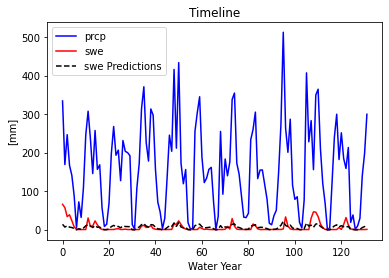

In [102]:
print('r-value = {}'.format(rvalue))
print('r-squared = {}'.format(rvalue**2))
print('p-value = {}'.format(pvalue))
print('standard error = {}'.format(stderr))

fig, ax = plt.subplots()

data.plot(x='idx', y=nam1, c='b', ax=ax, label=nam1)
data.plot(x='idx', y=nam2, c='r', ax=ax, label=nam2)

# Plot the predicted SWE at Blue Canyon
ax.plot(data.idx, BLC_pred, c='k', linestyle='--', label=nam2+' Predictions')

ax.set_title('Timeline')
ax.set_xlabel('Water Year')
ax.set_ylabel('[mm]');
plt.legend(loc="best")

# Multiple Linear Regression

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 

prcp = data.precip.values
et = data.et.values
swe = data.swe.values
et = data.et.values

print("Max count=%.1f" %np.nanmax(count),"Min count=%.1f" %np.nanmin(count),"Mean count=%.1f" %np.nanmean(count))
print("Max outflow=%.1f" %np.nanmax(outflow),"Min outflow=%.1f" %np.nanmin(outflow),"Mean outflow=%.1f" %np.nanmean(outflow))
print("Max temp=%.1f" %np.nanmax(temp),"Min temp=%.1f" %np.nanmin(temp),"Mean temp=%.1f" %np.nanmean(temp))
print("Max tu=%.1f" %np.nanmax(tu),"Min tu=%.1f" %np.nanmin(tu),"Mean tu=%.1f" %np.nanmean(tu))